# Категоризация Объявлений на Авито

Kaggle-соревнование, требующее построить модель, предсказывающую к какому одному из 50 классов относится объявление, на основе более чем 4,5 млн данных. Датасет содержит заголовок объявления, его описание и класс.

In [ ]:
import pandas as pd

In [ ]:
!pip install -q kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle

from google.colab import files
files.upload()

! mkdir -p  ~/.kaggle/
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

!kaggle competitions download -c avito-category-prediction

Processing /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303/kaggle-1.5.12-cp37-none-any.whl
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


Saving kaggle (1).json to kaggle (1).json
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
!unzip -q /content/avito-category-prediction.zip -d data

unzip:  cannot find or open /content/avito-category-prediction.zip, /content/avito-category-prediction.zip.zip or /content/avito-category-prediction.zip.ZIP.


In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
#train = pd.read_csv('/content/drive/My Drive/train.csv')

In [ ]:
!unzip -q /content/drive/MyDrive/train.csv.zip -d train

In [ ]:
train = pd.read_csv('/content/train/train.csv')

# Предварительный анализ датасета



In [ ]:
train.head()

,title,description,Category_name,Category
0,"Эбу Renault / Nissan 1,5 DCI Delphi 2001-2008 год","Комплект ЭБУ (мозги, компьютер мотора, двигате...",Запчасти и аксессуары,10
1,Утюг утп 1000 ватт СССР 1987 год,Продам/\n Фото № 1-2 /\n /\nУтюг УТП 1000 ватт...,Бытовая техника,21
2,Возвму машину с выкупом,Возьму машину в аренду с последующим выкупом н...,Предложение услуг,114
3,Полусапожки,"полусапожки в отличном состоянии, один раз оде...","Одежда, обувь, аксессуары",27
4,Босоножки кожаные,"Кожаные(натур) босоножки Karlo Pasolini, 40 рр...","Одежда, обувь, аксессуары",27


In [ ]:
train.isnull().any()

title            False
description       True
Category_name    False
Category         False
dtype: bool

In [ ]:
train.fillna(' ', inplace = True)

In [ ]:
train.isnull().any()

title            False
description      False
Category_name    False
Category         False
dtype: bool

In [ ]:
print(f'Всего {len(train.Category.unique())} уникальных классов')

Всего 50 уникальных классов


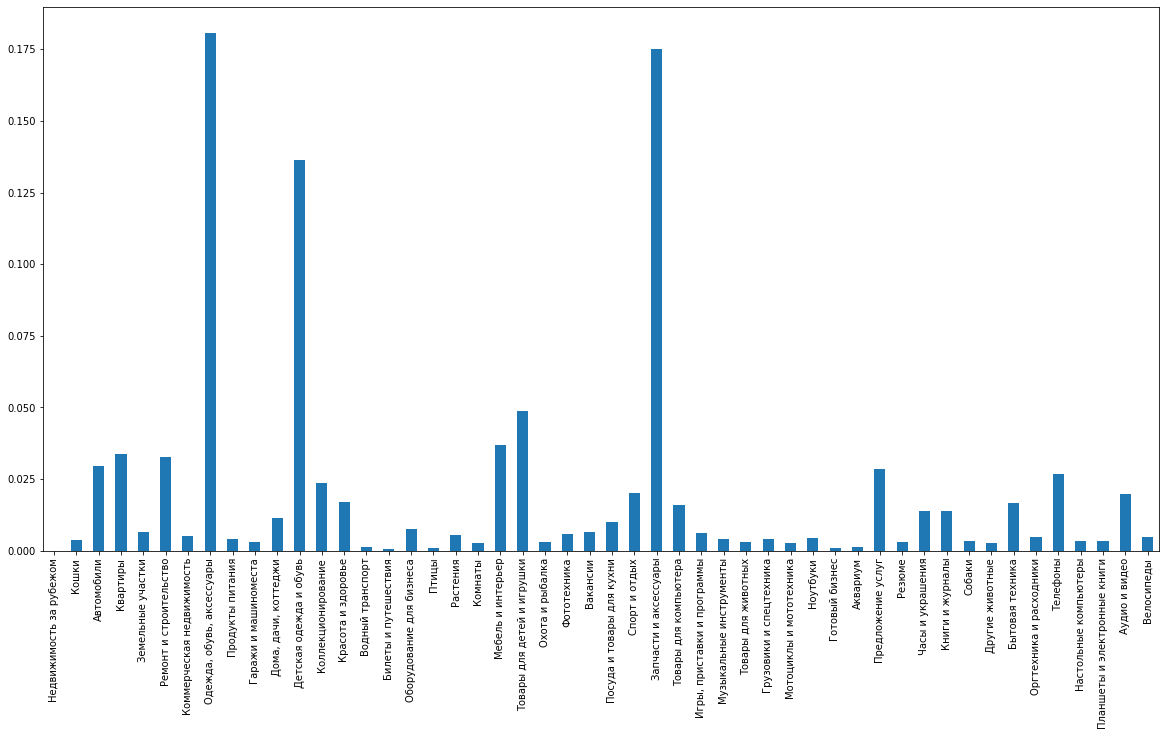

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
#plt.hist(train.Category, density=True, bins=int(len(train.Category.unique())))
train.Category_name.value_counts(normalize=True,sort=False).plot.bar()

In [ ]:
print(f'Наибольшая доля: {train.Category_name.value_counts(normalize=True)[0:1]}')
print(f'Наименьшая доля: {train.Category_name.value_counts(normalize=True)[-1:]}')

Наибольшая доля: Одежда, обувь, аксессуары    0.180707
Name: Category_name, dtype: float64
Наименьшая доля: Недвижимость за рубежом    0.000039
Name: Category_name, dtype: float64


# Обработка текста

Так как для работы с простыми моделями нет возможности использовать GPU и многие из них не поддерживают partial_fit, а возможности GoogleCollab ограничены ОЗУ = 13гб, эксперементальным путем был выясненен максимальный размер подвыборки, который вмещается в память Collab: 500к объектов. Поэтому некоторые следующие модели будут обучаться на батче с этим размером

In [ ]:
import numpy as np
np.random.seed(123)
rand = np.random.choice(np.arange(4234042),500000)

In [ ]:
train=train.iloc[rand]

Для того, чтобы объединить предобработку текста и токенизацию, было принято решение передавать в качестве аргумента векторизаторам кастомный токенизатор-preprocessor, объединяющий функции NLTK и pymorphy2 для лемматизации текста. Реализация составила ~4 минуты на 100к строк

In [ ]:
!pip install pymorphy2
!pip install pymorphy2-dicts
!pip install DAWG-Python

     |████████████████████████████████| 61kB 3.1MB/s 
     |████████████████████████████████| 8.2MB 8.0MB/s 
     |████████████████████████████████| 7.1MB 5.0MB/s 


In [ ]:
from pymorphy2 import MorphAnalyzer

pymorphy2_analyzer = MorphAnalyzer()

from string import punctuation
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download('punkt')

noise = stopwords.words('russian') + list(punctuation)

def my_tokenizer(t):
  a=[]
  for w in word_tokenize(t):
    if w.isalpha() and w.lower() not in noise:
      a.append(pymorphy2_analyzer.parse(w.lower())[0].normal_form)
  return a 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Каждая из моделей обучалась отдельно на описании, и заголовке, все они показали результаты сильно хуже, чем модели, обученные одновременно на всем имеющемся тексте. Обучать разные модели отдельно на описании, и отдельно на заголовке, чтобы в последствии, например, использовать стекинг моделей, не имело бы смысла, так как они имеют разный порядок качества, и последние не сравнимо хуже. Поэтому далее они обучаются на всем тексте

In [ ]:
train['text']=train['description']+' '+train['title']

Модели на векторизованных TfidfVectorizer'ом показали результаты такие же или хуже по сравнению с CountVectorizer, а этап обработки текста занимал примерно в 1,5 больше, поэтому предпочтение было отдано последнему

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cnt = CountVectorizer(tokenizer=my_tokenizer,max_features=200000)

transformed = cnt.fit_transform(train['text'].tolist())

In [ ]:
y=train['Category']
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
del train

In [ ]:
import scipy
transformed=scipy.sparse.load_npz('/content/drive/My Drive/transformed.nzp.npz')
X_train, X_test, y_train, y_test = train_test_split(transformed, y, test_size=0.2,random_state=123)

# LogReg, SGD

In [ ]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

grid = {"C":[1e-2, 1e-1, 1e0], "penalty":["l1","l2"]}

LogReg = LogisticRegression(verbose=100, n_jobs=-1, random_state=42, solver =)
logreg_cv=GridSearchCV(LogReg,grid,cv=10)

In [ ]:
logreg_cv.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


SGD_Classifier поддерживает partial_fit, однако векторизорвать больше, чем 500к объектов все равно не представляется вомзможным, поэтоиу SGD обучается на том же наборе данных

In [ ]:
sgd = SGDClassifier(verbose=100, n_jobs=-1, random_state=42)
sgd.fit(X_train,y_train)

pred_sgd = sgd.predict(X_test)

In [ ]:
#SGD_accuracy
print(f'Скор: {accuracy_score(y_test,pred_sgd)}')

Скор: 0.77666


In [ ]:
#logreg accuarcy
print(f'{logreg_cv.best_score_, 'accuracy')

0.82333 accuarcy


# LightGBM with SVD

In [ ]:
from sklearn.decomposition import TruncatedSVD
svd=TruncatedSVD(500)
print(sum(svd.explained_variance_))
transformed_svd=svd.fit_transform(X_train)

In [ ]:
boost_svd = lightgbm.LGBMClassifier(n_jobs=-1)
boost_svd.fit(transformed_svd,y_train)

pred_boost_svd = boost1.predict(svd.transform(X_test))

print(f'{accuracy_score(y_test,pred_boost_svd)} boost_svd accuracy')

# FastText

fasttext - библиотека, предоставляющая классифкатор, работающий более, чем на 150 языков, а также предобученные на разных корпусах модели, позволяющие как создавать эмбеддинги в пространстве модели, так и использовать предобученные модели для создания своих  собственных. Без предобученных векторов модель, обученная на 1кк объектах датасета показала резульата 0.88 f1-score на тесте и 0.9 f1-score на тесте на модели со встроенным валидационным автотюном

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
X = pd.read_csv('/content/drive/My Drive/avito1kk.csv') #500k #для оптимизации работы с CPU датасет со случайным миллионом строк был заранее загружен в файл

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
X['text']=X['description']+' '+X['title']

In [ ]:
!pip install fasttext
import fasttext
from gensim.utils import simple_preprocess

from sklearn.model_selection import train_test_split

y=X['Category']
X_train, X_valid, y_train, y_valid = train_test_split(X['text'], y, test_size=0.2,random_state=123)

Для работы с fasttext необходим текстовый файл, на каждой строке которого будут обозначены лейблы в формате '\_\_label\_\_{имя лейбла}' и далее после пробела должна следовать строка текста. Внутрь модели не встроен токенизатор, поэтому препроцессинг данных происходит с помощью токенизатора gensim, реализация которого оптимальнее собственного, реализованного выше, ~в 10 раз. Ниже прописана функция, выполняющая все необходимые для fasttext действия

In [ ]:
def create_txt(X,y,name):
  df = pd.DataFrame({'labels':len(X)*['__label__'], 'Category':y.reset_index()['Category'].astype('str')})
  df['labels+Category'] = df['labels']+df['Category']
  df['text'] = X.reset_index()['text'].apply(lambda x: ' '.join(simple_preprocess(x))) #препроцессинг текста
  
  df[['labels+Category', 'text']].to_csv(f'/content/{name}', 
                                          index = False, 
                                          sep = ' ',
                                          header = None, 
                                          escapechar = " ")

In [ ]:
create_txt(X_train,y_train,'train.txt')
create_txt(X_valid,y_valid,'test.txt')

In [ ]:
model = fasttext.train_supervised('train.txt', wordNgrams = 2, epoch = 25, lr=1,dim=100,loss='hs')

Результаты на train и test модели без автотюна: 

In [ ]:
model.test('test.txt')

(200000, 0.888395, 0.888395)

In [ ]:
model.test('train.txt')

(800000, 0.97414125, 0.97414125)

Результат модели с автотюном

In [ ]:
model = fasttext.train_supervised('train.txt', wordNgrams = 2, epoch = 25, lr=1,dim=100,loss='hs',autotuneValidationFile='test.txt', autotuneDuration=600)

In [ ]:
model.test('test.txt')

(200000, 0.905985, 0.905985)

In [ ]:
model.test('train.txt')

(800000, 0.9964125, 0.9964125)

# FastText на предобученных векторах

В собственную модель можно передать как аргумент предобученый словарь текстов. Для этого необходимо использовать .vec файл. На официальном сайте можно найти эти файлы, однако модель по какой-то причине выдавала ошибку не совпадения измерений векторов. То есть размерность вектора не соответствовала заявленной 300. Тогда одним из решений было сжать (для большего удобства, так ккак особого прироста в качестве это не давало) модель до размерности 100 и записать в файл .vec. Модель показала результаты f1-score 0.88, что говорит о не очень удачном transfer learninge (его отсутствии).

In [ ]:
import fasttext.util
fasttext.util.download_model('ru', if_exists='ignore')
ft = fasttext.load_model('cc.ru.300.bin')

In [ ]:
ft.get_dimension()

300

In [ ]:
fasttext.util.reduce_model(ft, 100)
ft.get_dimension()

In [ ]:
words = ft.get_words()

with open('/content/drive/MyDrive/cc-ru-100-vec-reduced.vec','w') as file_out:
    
    file_out.write(str(len(words)) + " " + str(ft.get_dimension()) + "\n")

    for w in words:
        v = f.get_word_vector(w)
        vstr = ""
        for vi in v:
            vstr += " " + str(vi)
        try:
            file_out.write(w + vstr+'\n')
            pass

In [ ]:
model = fasttext.train_supervised('train.txt', wordNgrams = 2, epoch = 25, lr=1,dim=100,loss='hs', pretrainedVectors='/content/drive/MyDrive/cc-ru-100-vec-reduced.vec')

In [ ]:
model.test('test.txt')

(200000, 0.88816, 0.88816)

# FastText-encoder-based models - SGD, LightGBM

Помимо возможности обучения модели самостоятельно, fasttext можно использовать как unsupervised модель - создавать эмбеддинги. Для этого с официального сайта была скачана модель .bin, которая была обучена на расской части Википедии. Готовые эмбеддинги были использвоаны в модели SGD, как более быстрый, но сравнительно менее качественый аналог логистической регресии, чтобы проверить гипотезху уместности построения векторов на предобученной модели и использовании сторонней моедли. Удалось векторизовать на CPU датасет размером 1млн и применить SGD c итоговым accuracy 0.74.

In [ ]:
import fasttext.util
fasttext.util.download_model('ru', if_exists='ignore')
ft = fasttext.load_model('cc.ru.300.bin')

In [ ]:
# import pandas as pd
# from google.colab import drive
# drive.mount('/content/drive')
X = pd.read_csv('/content/drive/My Drive/avito1kk.csv') #500k

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# X['text']=X['description']+' '+X['title']

In [ ]:
!pip install fasttext
import fasttext
from gensim.utils import simple_preprocess

from sklearn.model_selection import train_test_split

y=X['Category']
X_train_fast, X_valid_fast, y_train_fast, y_valid_fast = train_test_split(train['text'], y, test_size=0.2,random_state=123)

In [ ]:
train, val = pd.DataFrame(), pd.DataFrame(),
train['text'] = X_train_fast.reset_index()['text'].apply(lambda x: ' '.join(simple_preprocess(x)))
val['text'] = X_valid_fast.reset_index()['text'].apply(lambda x: ' '.join(simple_preprocess(x)))

Здесь происходит получение эмбеддингов из предобученной модели. Размерной векторов в модели - 300.

In [ ]:
from tqdm import tqdm
embeddings_train = []
for sentence in tqdm(train['text'].tolist()):  
  ft.get_sentence_vector(sentence)
  embeddings_train.append(ft.get_sentence_vector(sentence))

100%|██████████| 560000/560000 [03:56<00:00, 2372.71it/s]


In [ ]:
embeddings_val = []
for sentence in tqdm(val.text.tolist()):  
  ft.get_sentence_vector(sentence)
  embeddings_val.append(ft.get_sentence_vector(sentence))

100%|██████████| 140000/140000 [00:57<00:00, 2438.26it/s]


In [ ]:
import numpy as np

np.array(embeddings_val).shape

(140000, 300)

In [ ]:
tes = pd.DataFrame({'text':embeddings_train})
val = pd.DataFrame({'text':embeddings_val})

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

sgd = SGDClassifier(verbose=100, n_jobs=-1, random_state=42)
sgd.fit(embeddings_train,y_train_fast)
pred_sgd = sgd.predict(embeddings_val)

print(f'{accuracy_score(y_valid_fast, pred_sgd)} sgd accuracy')

In [ ]:
print(f'{accuracy_score(y_valid_fast, pred_sgd)} sgd accuracy')

0.7446928571428572 sgd accuracy


Обучение градиентного бустинга

In [ ]:
import lightgbm
from sklearn.metrics import f1_score

boost1 = lightgbm.LGBMClassifier(n_jobs=-1)
boost1.fit(embeddings_train,y_train, verbose=100)


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_valid, boost1.predict(embeddings_val)))

              precision    recall  f1-score   support

           9       0.82      0.79      0.81      6037
          10       0.87      0.86      0.86     35144
          11       0.01      0.37      0.03       234
          14       0.25      0.36      0.29       554
          19       0.61      0.64      0.62      6511
          20       0.70      0.62      0.66      7391
          21       0.64      0.60      0.62      3380
          23       0.22      0.34      0.27       538
          24       0.76      0.58      0.66      6607
          25       0.74      0.72      0.73      2359
          26       0.76      0.77      0.77      1273
          27       0.78      0.77      0.78     35714
          28       0.67      0.67      0.67      2795
          29       0.81      0.72      0.76     27349
          30       0.69      0.64      0.66      9788
          31       0.22      0.28      0.24       661
          32       0.57      0.39      0.46      4003
          33       0.00    

# Сабмит FastText

Так как fasttext показал наилучшие результаты, то сабмит делался на основе этой модели

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#del X
test = pd.read_csv('/content/data/test.csv')
test.fillna(' ', inplace = True)
test['text']=test['title']+' '+test['description']

In [ ]:
test['text'] = test['text'].apply(lambda x: ' '.join(simple_preprocess(x)))

In [ ]:
predictions = model.predict(test.text.tolist())[0]

In [ ]:
preds=[]
for lst in predictions:
   preds.extend(lst)
   preds[-1] = preds[-1].split('__label__')[1]

In [ ]:
my_submit = pd.DataFrame({'Id': test['itemid'], 'Category': preds})
my_submit.to_csv('/content/sub800k.csv', index=False)